##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This is an adapted code from [`pix2pix: Image-to-image translation with a conditional GAN`](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial.

# README

This is the code used for the work:
`Image-to-image model to predict CFD from NWP inputs over complex terrains`

You can download the data used from: [Link text Here](www.google.es)

## Citation

If you found this code useful please cite our work as:

```
@article{

}
``` 

## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint

import os
import sys
import time
import datetime


import numpy as np
import pandas as pd
import matplotlib.colors as colors

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

## Auxiliary steps

In [3]:
# Set memory growth for the GPU to reduce excesice VRAM utilization
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Create, if it not exists, a folder
def creaCarpeta(ruta_save_fig='/folder/folder2'):
    try: 
        os.makedirs(ruta_save_fig)
    except OSError:
        if not os.path.isdir(ruta_save_fig):
            raise
    return ruta_save_fig+"/"

2023-11-08 14:00:08.506267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 14:00:08.513994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 14:00:08.514087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Paths for data inputs, logs, checkpoints and results

In [4]:
# Path for the input data
data_folder = '/home/jmilla/DoctoradoData/piri10h_datasets/dataPiri1h_resMean.npz'

## Load data

In [5]:
compNUM = 2

data = np.load(data_folder)

#([Ux(0), Uy(1), Uz(2), u(3), v(4), wa(5)], dates, lat, lon, eta)
velTrain = data['velTrain'] 
velTest = data['velTest']
# print(velTrain.shape, velTest.shape)

cfdTrain = velTrain[0:compNUM,:,:,:,0:1]
cfdTrain = cfdTrain.swapaxes(0,-1)[0]
wrfTrain = velTrain[3:(3+compNUM),:,:,:,0:1]
wrfTrain = wrfTrain.swapaxes(0,-1)[0]

cfdTest = velTest[0:compNUM,:,:,:,0:1]
cfdTest = cfdTest.swapaxes(0,-1)[0]
wrfTest = velTest[3:(3+compNUM),:,:,:,0:1]
wrfTest = wrfTest.swapaxes(0,-1)[0]

display.display(('cfdTrain', cfdTrain.shape), (cfdTrain.max((0,1,2)), cfdTrain.min((0,1,2))))
display.display(('wrfTrain', wrfTrain.shape), (wrfTrain.max((0,1,2)), wrfTrain.min((0,1,2))))
display.display(('cfdTest', cfdTest.shape), (cfdTest.max(), cfdTest.min()))
display.display(('wrfTest', wrfTest.shape), (wrfTest.max(), wrfTest.min()))

('cfdTrain', (193, 128, 128, 2))

(array([72.61593098, 40.02911067]), array([-32.50536049, -55.80883182]))

('wrfTrain', (193, 128, 128, 2))

(array([29.26390739, 25.92597847]), array([-16.46116425, -32.39328918]))

('cfdTest', (80, 128, 128, 2))

(66.36400683607424, -44.78294181842699)

('wrfTest', (80, 128, 128, 2))

(27.330962727814295, -26.35773396335445)

In [6]:
BUFFER_SIZE = 193
BATCH_SIZE = 32
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [7]:
# Normalizing the images to [-1, 1]
def normalize(inp, real):
    inp = (inp + 30) / 60
    inp = tf.cast(inp*2.0 - 1.0, tf.float32)
    
    real = (real + 60) / 140
    real = tf.cast(real*2.0 - 1.0, tf.float32)

    return inp, real

## Build an input pipeline with `tf.data`

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((wrfTrain, cfdTrain))
test_dataset = tf.data.Dataset.from_tensor_slices((wrfTest, cfdTest))

train_dataset = train_dataset.map(normalize,
                                  num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=1234)
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = train_dataset.take(int(len(train_dataset)*0.2))
train_dataset = train_dataset.skip(int(len(train_dataset)*0.2))

test_dataset = test_dataset.map(normalize,
                                num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-11-08 14:00:13.617387: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 14:00:13.618720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 14:00:13.618861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 14:00:13.618936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Build the generator

The generator of the pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> >PReLU
- Each block in the decoder is: Transposed convolution -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [9]:
OUTPUT_CHANNELS = compNUM

In [10]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.PReLU())

    return result

Define the upsampler (decoder):

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.PReLU())

    return result

Define the generator with the downsampler and the upsampler:

In [12]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, compNUM])

    down_stack = [
        downsample(64, 5, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, 5),  # (batch_size, 32, 32, 128)
        downsample(256, 5),  # (batch_size, 16, 16, 256)
        downsample(512, 5),  # (batch_size, 8, 8, 512)
        downsample(512, 5),  # (batch_size, 4, 4, 512)
        downsample(512, 5),  # (batch_size, 2, 2, 512)
        downsample(512, 5),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 5, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 5, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 5, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 5),  # (batch_size, 16, 16, 768)
        upsample(256, 5),  # (batch_size, 32, 32, 384)
        upsample(128, 5),  # (batch_size, 64, 64, 192)
    ]
    
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
#                                          activation=None)  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

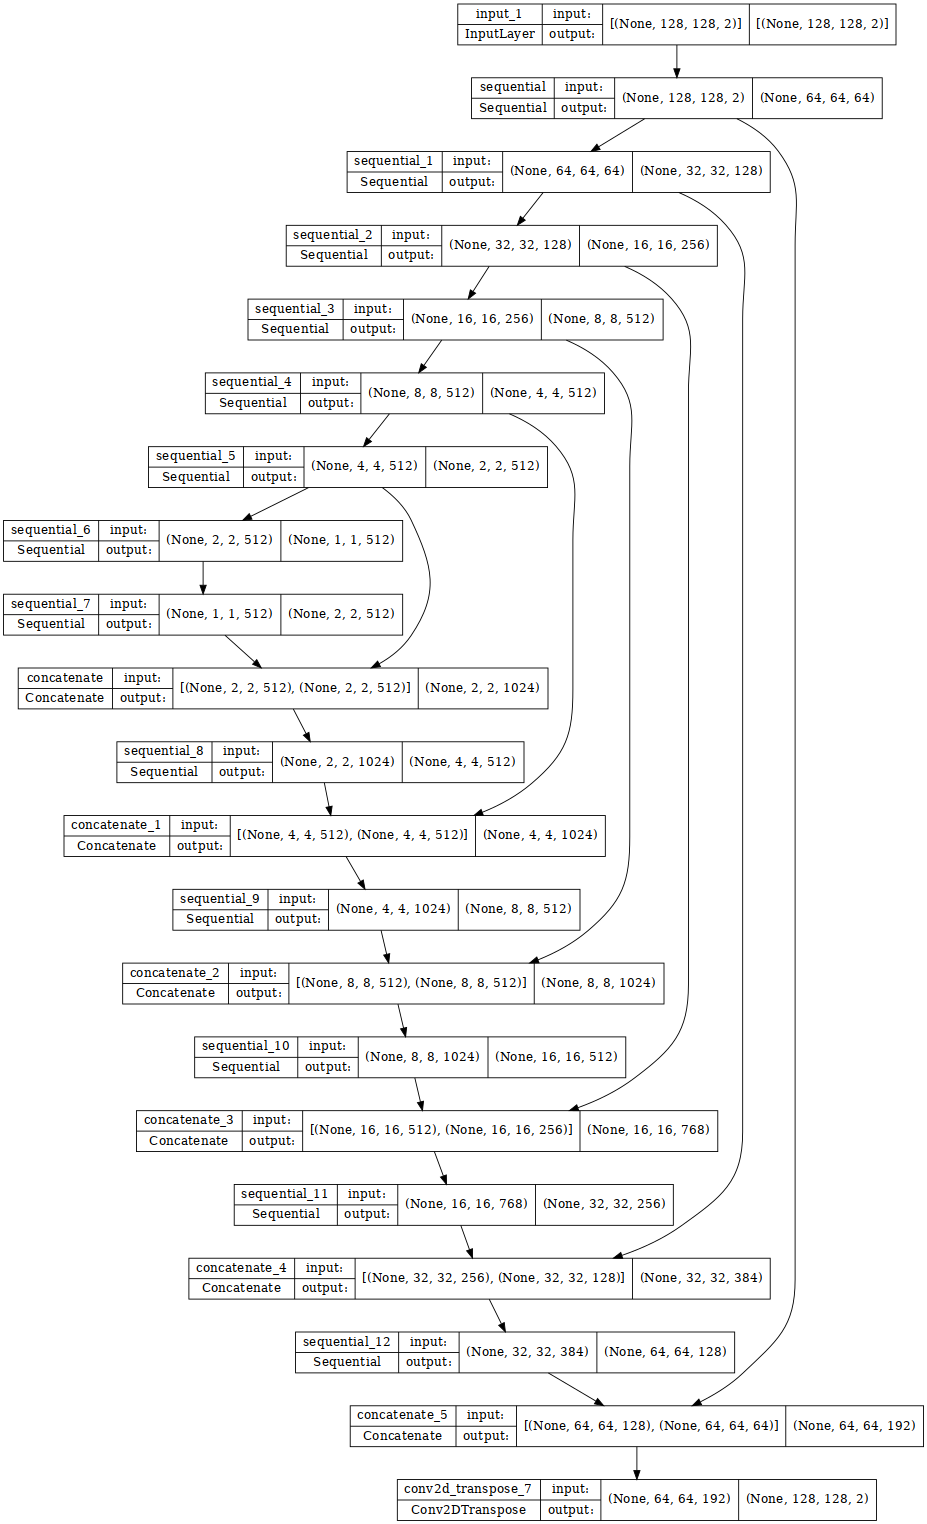

In [13]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# generator.summary()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


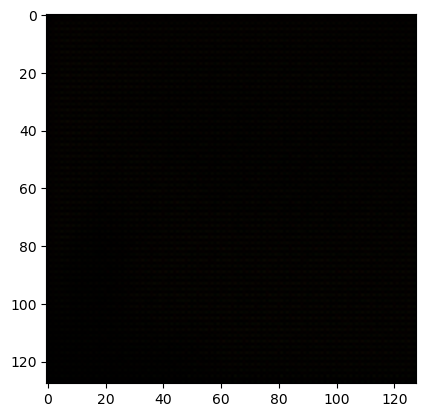

In [18]:
gen_output = generator(inp, training=False)

plt.imshow(tf.concat((gen_output[0, ...], 
                          tf.zeros_like(gen_output[0, ...,:1])), axis=-1))


### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [19]:
auxloss = custlos.loss8()

def mae_umb (y_true, y_pred, umbral=2):
    y_true_real = (y_true*0.5+0.5)*140.0-60.0
    vel_true = auxloss.calculaVel(y_true_real)

    ae = auxloss.ae(y_true, y_pred)
    ae = tf.reduce_mean(ae, axis=-1)

    indx = tf.where(tf.math.less(vel_true, umbral))
    ae = tf.tensor_scatter_nd_update(
        ae,
        indx,
        tf.gather_nd(tf.zeros_like(ae), indx)
    )

    return tf.reduce_mean(ae)

mae_umb(tar, inp), mae_umb(inp, tar), auxloss(inp, tar)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.31957293>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.32936263>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.38229388>)

In [20]:
LAMBDA = 1000

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
#   l1_loss = mae_umb(target, gen_output, 2)
#   l1_loss = auxloss(target, gen_output)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [23]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

#   inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  inp = tf.keras.layers.Input(shape=[128, 128, OUTPUT_CHANNELS], name='input_image')
#   tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  tar = tf.keras.layers.Input(shape=[128, 128, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 7, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 7)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 7)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=2,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

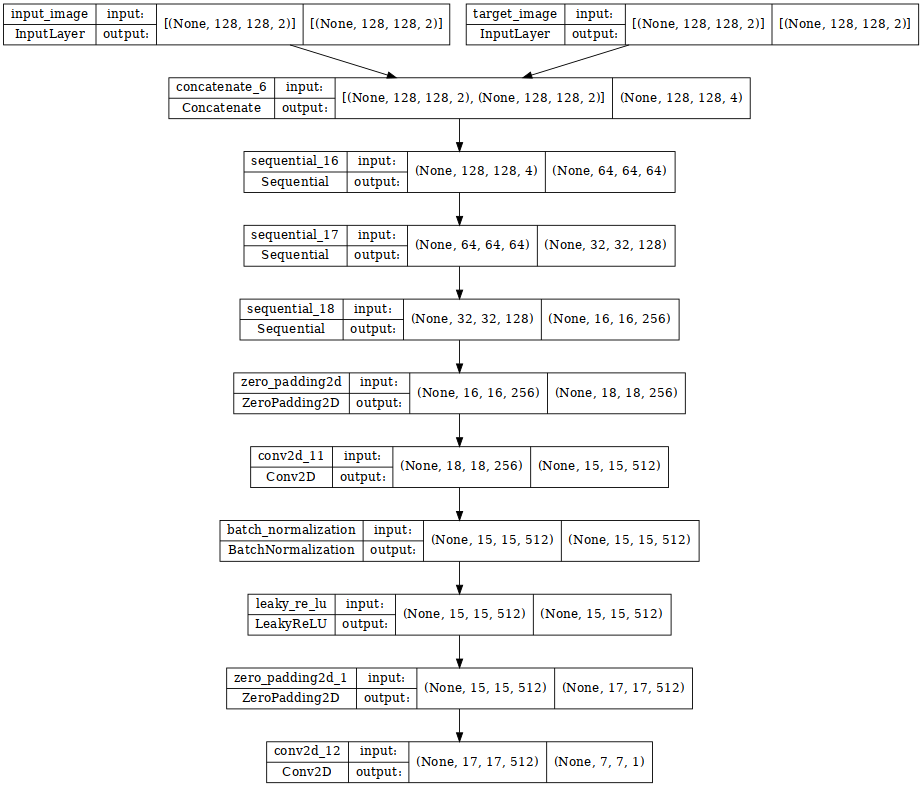

In [24]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

In [25]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 128, 128, 4)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

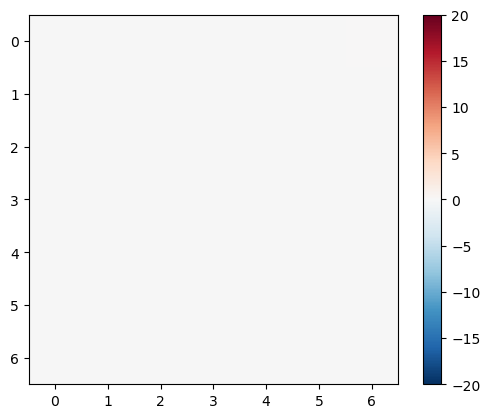

In [26]:
disc_out = discriminator([inp, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [28]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate
        self.lr = initial_learning_rate
        
    def numpy(self):
        return self.lr
    
    @tf.function
    def __call__(self, step):
        
        window = 2500
        return self.lr*(0.75**(step//window))

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
# checkpoint_dir = './training_checkpoints'
checkpoint_dir = '/home/jmilla/ramdisk/pix2pix_own_ckpt_'+socket.gethostname()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [31]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    
    # Getting the pixel values in the [0, 1] range to plot.
#     plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.imshow(tf.concat((display_list[i], 
                          tf.zeros_like(display_list[i][...,:1])), axis=-1) * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction  

In [32]:
# def generate_images(model, test_input, tar):
#   prediction = model(test_input, training=True)
#   plt.figure(figsize=(15, 15))

#   display_list = [test_input[0], tar[0], prediction[0]]
#   display_list = [tf.concat((display_list[i], 
#                              tf.zeros_like(display_list[i][...,:1])), 
#                             axis=-1).numpy() for i in range(3)]
#   title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
#   vmin = display_list[0].min()
#   vmax = display_list[0].max()
#   for aux in display_list:
#     vmin = np.minimum(vmin, aux.min())
#     vmax = np.maximum(vmax, aux.max())
    
#   for i in range(3):
#     plt.subplot(1, 3, i+1)
#     plt.title(title[i])
    
#     # Getting the pixel values in the [0, 1] range to plot.
# #     plt.imshow(display_list[i] * 0.5 + 0.5)
#     plt.imshow((display_list[i] - vmin)/(vmax-vmin))
#     plt.axis('off')
#   plt.show()
#   return prediction  

Test the function:

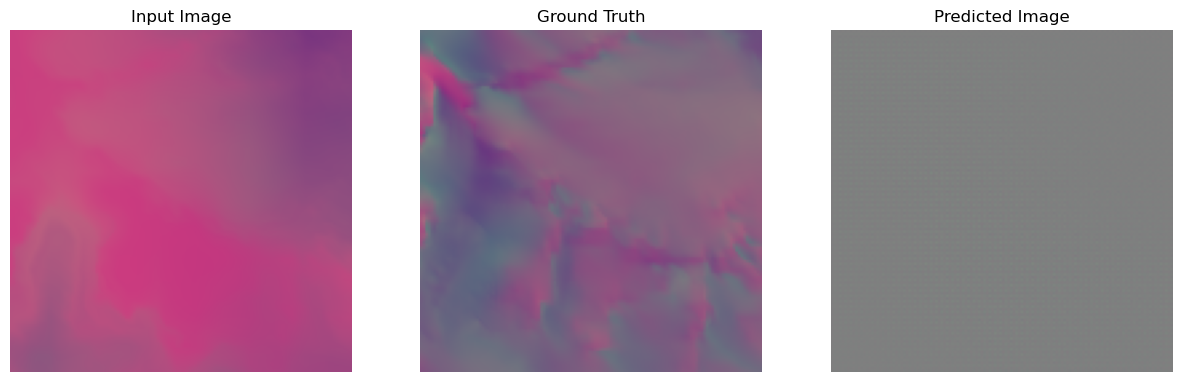

In [33]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [34]:
log_dir = "logs/"
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
current_time = 'rehaulV2_{:05d}_{:.3e}_{:1d}'.format(LAMBDA, generator_optimizer.lr.numpy(), OUTPUT_CHANNELS)

summary_writer_train = tf.summary.create_file_writer(
  log_dir + current_time + '/train')
summary_writer_val = tf.summary.create_file_writer(
  log_dir + current_time + '/validation')

In [35]:
@tf.function
def train_step(input_image, target, step):
    
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
#   generator_gradients = gen_tape.gradient(gen_l1_loss,
#                                           generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, gen_total_loss

In [36]:
@tf.function
def test_step(input_image, target, step):
    
  gen_output = generator(input_image, training=True)

  disc_real_output = discriminator([input_image, target], training=True)
  disc_generated_output = discriminator([input_image, gen_output], training=True)

  gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
  disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, gen_total_loss

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [37]:
def fit(train_ds, test_ds, epochs, 
        generator_optimizer=generator_optimizer, 
        discriminator_optimizer=discriminator_optimizer):
    tloss_list = []
    dloss_list = []
    gloss_list = []
    
    tlossOLD = 1e10
#     example_input, example_target = next((iter(test_ds.take(1))))
    for example_input, example_target in test_dataset.take(1):
        pass
    start = time.time()
    for epoch in range(epochs):
        # lr schedule
#         lr = generator_optimizer.lr(epoch)
        lr = generator_optimizer.lr.numpy()
            
        if (epoch) % 10 == 0:
            display.clear_output(wait=True)

            if epoch != 0:
                print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')

            start = time.time()
            
            generate_images(generator, example_input, example_target)
#             print(f"Epoch: {epoch}")
#             print('Old loss: {:.4e} --> New loss: {:.4e}'.format(tlossOLD, tlossOLD), end='\r', flush=True)
        
        # Traingin for each batch
        for step, (input_image, target) in tqdm(train_ds.enumerate(),  desc=f'Epoch {epoch}', leave=False):
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, gen_total_loss = train_step(input_image, target, step)
        
        with summary_writer_train.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
            tf.summary.scalar('TOTAL_loss', gen_total_loss + disc_loss, step=epoch)
            tf.summary.scalar('lr', lr, step=epoch)
            
        tloss_list.append(gen_total_loss + disc_loss)
        dloss_list.append(disc_loss)
        gloss_list.append(gen_gan_loss)
        
        # Test loop
        for step, (input_image, target) in test_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss, gen_total_loss = test_step(input_image, target, step)

        with summary_writer_val.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
            tf.summary.scalar('TOTAL_loss', gen_total_loss + disc_loss, step=epoch)
            
        tloss_test = gen_total_loss + disc_loss

        if tloss_test<tlossOLD:
#             print('Old loss: {:.4e} --> New loss: {:.4e}'.format(tlossOLD, tloss_test), end='\r', flush=True)
            old_counter = checkpoint.save_counter.numpy()
            checkpoint.save_counter.assign(0)
            checkpoint.save(file_prefix=checkpoint_prefix)
            tlossOLD = tloss_test
            checkpoint.save_counter.assign(old_counter)
            
#         # Save (checkpoint) the model every 1k steps
#         if (epoch%1000==0):
#             checkpoint.save(file_prefix=checkpoint_prefix)
        
        if epoch>300:        
            fit_curve = tf.concat((tf.concat(tloss_list, axis=0)[...,tf.newaxis], 
                          tf.concat(gloss_list, axis=0)[...,tf.newaxis], 
                          tf.concat(dloss_list, axis=0)[...,tf.newaxis]), axis=1)
            
            df = pd.DataFrame(fit_curve, columns=['Tot', 'G', 'D'])
            rolling = df.rolling(300).std()
            
            if ((rolling.G.iloc[-1]<rolling.G.max()*0.1) |
                (rolling.D.iloc[-1]<rolling.D.max()*0.1)):
                checkpoint.save(file_prefix=checkpoint_prefix)
                break
                        
    return fit_curve

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

In [38]:
%load_ext tensorboard
%tensorboard --logdir {log_dir} --host 192.168.2.113 --port 6010

Reusing TensorBoard on port 6010 (pid 747036), started 11 days, 8:08:03 ago. (Use '!kill 747036' to kill it.)

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

Finally, run the training loop:

Time taken for 10 epochs: 404.69 sec



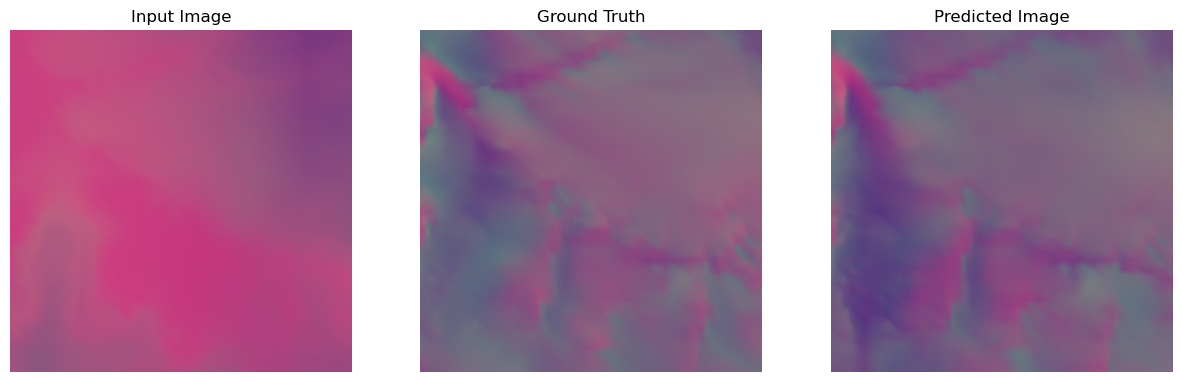

Epoch 39294:   0%|          | 0/6 [00:00<?, ?it/s]         

In [ ]:
%%time
# try:
#     # Restoring the latest checkpoint in checkpoint_dir
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# except:
#     raise
    
fit_curve = fit(train_dataset, val_dataset, epochs=50000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# checkpoint.restore('/home/jmilla/ramdisk/pix2pix_own_ckpt_nodo13/ckpt-9')

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
norm = colors.Normalize(vmin=-60, vmax=80)

pred_list = []

for inp, tar in test_dataset:
    pred = generate_images(generator, inp, tar)
    pred01 = (pred.numpy()*0.5+0.5)
    tar01 = (tar.numpy()*0.5+0.5)
    
    print(pred01.min(), pred01.max())
    print(tar01.min(), tar01.max())
    print(norm.inverse(pred01).min(), norm.inverse(pred01).max())
    print(norm.inverse(tar01).min(), norm.inverse(tar01).max())
    
    try:
        pred_list = np.concatenate((pred_list, norm.inverse(pred01)))
    except ValueError:
        pred_list = norm.inverse(pred01)
    
#     try:
#         pred_list = np.concatenate((pred_list, pred.numpy()))
#     except ValueError:
#         pred_list = pred.numpy()

In [ ]:
# Run the trained model on a few examples from the test set
norm = colors.Normalize(vmin=-60, vmax=80)

train_list = []

for inp, tar in train_dataset:
    pred = generate_images(generator, inp, tar)
    pred01 = (pred.numpy()*0.5+0.5)
    tar01 = (tar.numpy()*0.5+0.5)
    print(pred01.min(), pred01.max())
    print(tar01.min(), tar01.max())
    print(norm.inverse(pred01).min(), norm.inverse(pred01).max())
    print(norm.inverse(tar01).min(), norm.inverse(tar01).max())
    
    try:
        train_list = np.concatenate((train_list, norm.inverse(pred01)))
    except ValueError:
        train_list = norm.inverse(pred01)
    
#     try:
#         train_list = np.concatenate((train_list, pred.numpy()))
#     except ValueError:
#         train_list = pred.numpy()

In [ ]:
# assert False

In [ ]:
wdir = creaCarpeta('./results_rehaulV2_{:05d}_{:.3e}_{:1d}'.format(LAMBDA, generator_optimizer.lr.numpy(), OUTPUT_CHANNELS))
np.savez_compressed(wdir+'results_pix2pix_notebook', 
                    train=train_list[...,:OUTPUT_CHANNELS], 
                    test=pred_list[...,:OUTPUT_CHANNELS], 
                    loss=np.array([np.nan]),
                    val_loss=np.array([np.nan]),
                    hist=None)

In [ ]:


df = pd.DataFrame(fit_curve, columns=['Tot', 'G', 'D'])

In [ ]:
df.rolling(200).std().D.iloc[-1]

In [ ]:
df.rolling(200).std()

In [ ]:
df.rolling(200).std().min(), df.rolling(200).std().max()